In [1]:
  import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)


Using PyTorch version: 1.7.0+cu101  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                               train = False,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw


Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw


Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw


Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
for X_train, y_train in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


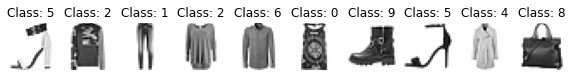

In [16]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
  plt.title('Class: ' + str(y_train[i].item()))

In [17]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),)
    
    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28 * 28),)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [18]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [19]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, _) in enumerate(train_loader):
    image = image.view(-1, 28 * 28).to(DEVICE)
    target = image.view(-1, 28 * 28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [23]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []

  with torch.no_grad():
    for image, _ in test_loader:
      image = image.view(-1, 28 * 28).to(DEVICE)
      target = image.view(-1, 28 * 28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to('cpu'))
      gen_image.append(decoded.to('cpu'))
        
  test_loss /= len(test_loader.dataset)
  return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.007733
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.008647
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.010088
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.007264
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.007218
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.009993
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.006673
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.009276
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.010526
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.009891

[EPOCH: 1], 	Test Loss: 0.0003


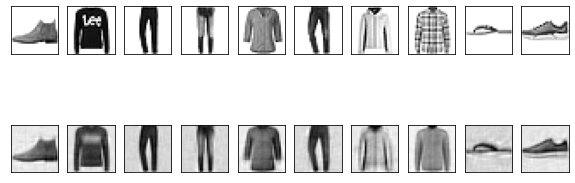

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.011167
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.009243
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.009392
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.008082
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.007367
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.009368
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.008787
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.010320
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.008278
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.007476

[EPOCH: 2], 	Test Loss: 0.0003


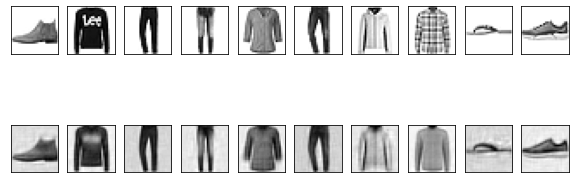

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.010493
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.007942
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.007498
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.010501
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.009756
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.008137
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.008920
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.007892
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.009127
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.007366

[EPOCH: 3], 	Test Loss: 0.0003


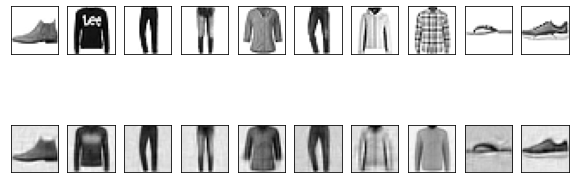

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.008406
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.009532
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.006631
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010142
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.009192
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.010217
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.008116
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.008865
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.008720
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.007960

[EPOCH: 4], 	Test Loss: 0.0003


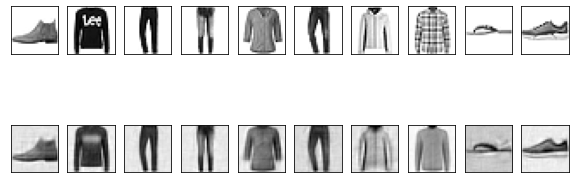

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.009246
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009512
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.008874
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.008233
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.010463
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.009029
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.008893
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.010005
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.007993
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.008351

[EPOCH: 5], 	Test Loss: 0.0003


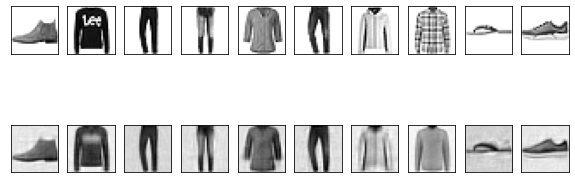

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.009386
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.008844
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.008603
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.009327
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.008888
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.010742
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009485
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.007807
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.009970
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.010878

[EPOCH: 6], 	Test Loss: 0.0003


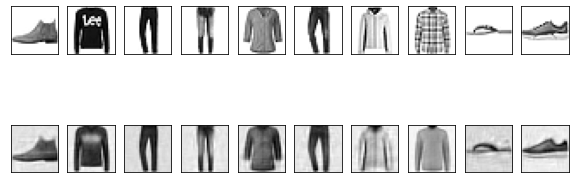

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.008506
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.009870
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.008087
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.009260
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.010918
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.007770
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.008104
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.011299
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.008539
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.007810

[EPOCH: 7], 	Test Loss: 0.0003


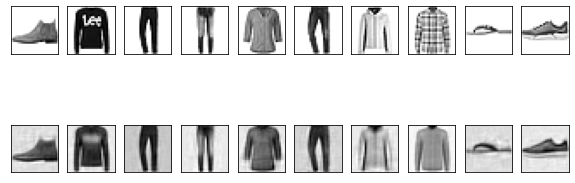

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.009068
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.009847
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.010176
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.011116
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.009426
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.007649
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.006898
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.008778
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.010120
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.009286

[EPOCH: 8], 	Test Loss: 0.0003


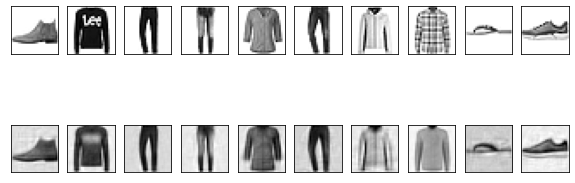

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.008806
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.007900
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.007205
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.010124
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.009585
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.012368
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.008606
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.008106
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.009794
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.006999

[EPOCH: 9], 	Test Loss: 0.0003


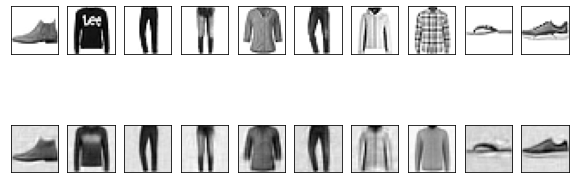

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.008195
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.009255
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.008409
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.007230
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.010538
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.008434
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.009740
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.011162
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.009696
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.010566

[EPOCH: 10], 	Test Loss: 0.0003


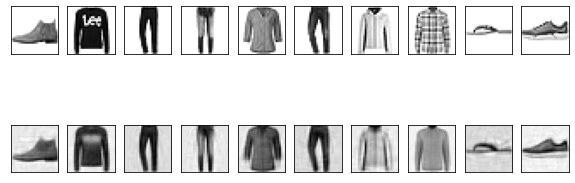

In [24]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
  f, a = plt.subplots(2, 10, figsize = (10, 4))
  for i in range(10):
    img = np.reshape(real_image[0][i],(28, 28))
    a[0][i].imshow(img, cmap = "gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img = np.reshape(gen_image[0][i],(28, 28))
    a[1][i].imshow(img, cmap = "gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())

  plt.show()